#Potato Disease Indentification 🌿

Dataset credits: https://www.kaggle.com/arjuntejaswi/plant-village

In [ ]:
# To connect google drive to google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import all the Dependencies

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
print("GPU", "Available (YESS!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

GPU Available (YESS!!)


### Set all the Constants

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS=3
EPOCHS=50

### Import data into tensorflow dataset object

We will use image_dataset_from_directory api to load all images in tensorflow dataset: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Potato Disease Identification/Data",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names 

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
len(dataset)

68

In [ ]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 1 1 0 0 0 1 1 0 2 0 0 1 1 0 0 0 0 1 2 1 0 0 1 1 0 0 0 2 0 0]


As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels 

In [ ]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch[0].numpy())

[[[176. 178. 190.]
  [181. 183. 195.]
  [177. 179. 191.]
  ...
  [187. 185. 199.]
  [180. 178. 192.]
  [166. 164. 178.]]

 [[172. 174. 186.]
  [165. 167. 179.]
  [169. 171. 183.]
  ...
  [112. 110. 124.]
  [162. 160. 174.]
  [123. 121. 135.]]

 [[181. 183. 195.]
  [164. 166. 178.]
  [153. 155. 167.]
  ...
  [166. 164. 178.]
  [128. 126. 140.]
  [107. 105. 119.]]

 ...

 [[171. 169. 182.]
  [166. 164. 177.]
  [159. 157. 170.]
  ...
  [144. 141. 152.]
  [136. 133. 144.]
  [114. 111. 122.]]

 [[171. 169. 182.]
  [166. 164. 177.]
  [160. 158. 171.]
  ...
  [146. 143. 154.]
  [120. 117. 128.]
  [152. 149. 160.]]

 [[172. 170. 183.]
  [172. 170. 183.]
  [173. 171. 184.]
  ...
  [137. 134. 145.]
  [120. 117. 128.]
  [156. 153. 164.]]]


## Data Visualization

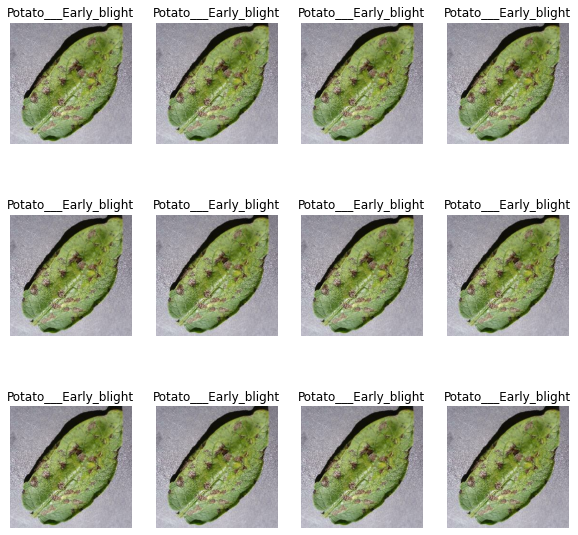

In [ ]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")

### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [ ]:
len(dataset)

In [ ]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [ ]:
train_ds = dataset.take(54)
len(train_ds)

54

In [ ]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [ ]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [ ]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [ ]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
  
  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)
  
  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)

  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)


  return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds), len(val_ds), len(test_ds)

(54, 6, 8)

### Cache, Shuffle, and Prefetch the Dataset
Optimizing datas or Tensorflow pipeline performance

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE) 
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE) 
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE) 

## Building the Model

### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. 
Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).
This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

#### Applying Data Augmentation to Train Dataset

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks. 

In [ ]:
input_shape =  (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes =3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),   
    ])
model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [ ]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

Checking GPU availability

In [ ]:
print("GPU", "Available (YESS!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

GPU Available (YESS!!)


In [ ]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
54/54 [==============================] - 9s 176ms/step - loss: 0.8573 - accuracy: 0.5515 - val_loss: 0.7843 - val_accuracy: 0.6562
Epoch 2/50
54/54 [==============================] - 4s 71ms/step - loss: 0.6096 - accuracy: 0.7575 - val_loss: 0.5311 - val_accuracy: 0.7917
Epoch 3/50
54/54 [==============================] - 4s 71ms/step - loss: 0.4116 - accuracy: 0.8328 - val_loss: 0.3238 - val_accuracy: 0.8646
Epoch 4/50
54/54 [==============================] - 4s 71ms/step - loss: 0.2786 - accuracy: 0.8906 - val_loss: 0.2625 - val_accuracy: 0.8958
Epoch 5/50
54/54 [==============================] - 4s 72ms/step - loss: 0.2079 - accuracy: 0.9271 - val_loss: 0.7803 - val_accuracy: 0.7812
Epoch 6/50
54/54 [==============================] - 4s 72ms/step - loss: 0.2275 - accuracy: 0.9167 - val_loss: 0.2303 - val_accuracy: 0.9219
Epoch 7/50
54/54 [==============================] - 4s 71ms/step - loss: 0.1220 - accuracy: 0.9618 - val_loss: 0.4253 - val_accuracy: 0.8698
Epoch 8/50
5

## Model Evaluation

Scores is just a list containing loss and accuracy value

In [ ]:
score = model.evaluate(test_ds)

8/8 [==============================] - 0s 36ms/step - loss: 0.0153 - accuracy: 0.9961


In [ ]:
score

[0.015263528563082218, 0.99609375]

In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history.history["accuracy"]

[0.5515046119689941,
 0.7575231194496155,
 0.8327546119689941,
 0.890625,
 0.9270833134651184,
 0.9166666865348816,
 0.9618055820465088,
 0.9693287014961243,
 0.9334490895271301,
 0.9589120149612427,
 0.9646990895271301,
 0.9837962985038757,
 0.9762731194496155,
 0.9710648059844971,
 0.9675925970077515,
 0.9751157164573669,
 0.9583333134651184,
 0.9797453880310059,
 0.9884259104728699,
 0.9861111044883728,
 0.9756944179534912,
 0.9895833134651184,
 0.9855324029922485,
 0.9884259104728699,
 0.9658564925193787,
 0.9861111044883728,
 0.9832175970077515,
 0.9780092835426331,
 0.9837962985038757,
 0.9936342835426331,
 0.9895833134651184,
 0.9837962985038757,
 0.9814814925193787,
 0.9756944179534912,
 0.9924768805503845,
 0.9918981194496155,
 0.9878472089767456,
 0.9849537014961243,
 0.9884259104728699,
 0.9820601940155029,
 0.9924768805503845,
 0.9936342835426331,
 0.9884259104728699,
 0.9942129850387573,
 0.9884259104728699,
 0.9895833134651184,
 0.9878472089767456,
 0.9953703880310059,
 0

In [ ]:
len(history.history["accuracy"])

50

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

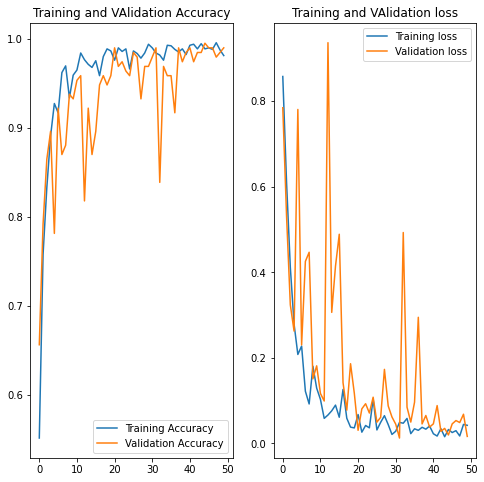

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label="Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and VAlidation Accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label="Training loss")
plt.plot(range(EPOCHS), val_loss, label="Validation loss")
plt.legend(loc="upper right")
plt.title("Training and VAlidation loss")
plt.show()

## Run prediction on a sample image

first image to predict
first image's actual label :  Potato___Late_blight
Prediction of each class : [2.7237923e-10 9.9998367e-01 1.6383456e-05]
Predicted label number : 1
Predicted label : Potato___Late_blight


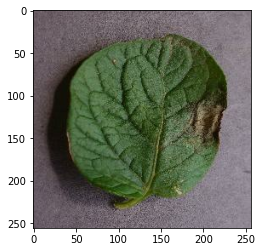

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

  first_image = (images_batch[0].numpy().astype('uint8'))
  first_label = labels_batch[0].numpy()

  print("first image to predict")
  plt.imshow(first_image)
  print("first image's actual label : ", class_names[first_label])

  batch_prediction = model.predict(images_batch)
  print("Prediction of each class :", batch_prediction[0])
  print("Predicted label number :", np.argmax(batch_prediction[0]))
  print("Predicted label :", class_names[np.argmax(batch_prediction[0])])

# Saving model

In [ ]:
model_version = 1
model.save(f"/content/drive/MyDrive/Potato Disease Identification/model/{model_version}") 

Storing model in single file

In [ ]:
model.save("../potatoes.h5")